In [2]:
import pylab as pl
import numpy as np
from scipy.io import loadmat
from sklearn.metrics import accuracy_score
import pdb

In [3]:
def load_data(fname):
    # load the data
    data = loadmat(fname)
    # extract images and labels
    imgs = data['data_patterns']
    labels = data['data_labels']
    return imgs, labels

In [4]:
def predict_ncc(X,mu):
    # do nearest-centroid classification
    # initialize distance matrix with zeros and shape (602,2) - why?
    NCdist = np.zeros((X.shape[1], mu.shape[1]))
    # compute euclidean distance to centroids
    # loop over both classes
    for ic in np.arange(mu.shape[-1]):
        # calculate distances of every point to centroid
        # in one line
        NCdist[:,ic] = np.sqrt(((X - mu[:, ic, None]) ** 2).sum(axis=0))

    # assign the class label of the nearest (euclidean distance) centroid
    Yclass = NCdist.argmin(axis=1)
    return Yclass

In [5]:
def perceptron_train(X,Y,Xtest,Ytest,iterations=100,eta=.1):
    # initialize accuracy vector
    acc = np.zeros(iterations)
    # initialize weight vector
    weights = np.zeros(X.shape[0])
    # loop over iterations    
    for it in np.arange(iterations):
        # indices of misclassified data
        Ypred = np.sign(np.dot(weights, X))
        wrong = np.where(Ypred != Y)[0]
        # check if there is misclassified data
        if wrong.shape[0] > 0:
            # pick a random misclassified data point
            rit = np.random.choice(wrong)
            # update weight vector
            weights += eta * Y[rit] * X[:, rit]
            # compute error
            acc[it] = accuracy_score(Ytest, np.sign(np.dot(weights, Xtest)))

    # return weight vector and error
    return weights,acc

In [6]:
def ncc_train(X,Y,Xtest,Ytest):
    # initialize accuracy vector
    acc = np.zeros(X.shape[-1])
    # unique class labels
    cids = np.unique(Y)
    # initialize mu, shape should be (256,2) - why? 
    mu = np.zeros((256, 2)) # because 2 classes
    # initialize counter , shape should be (2,) - why?
    Nk = np.zeros(2,) # for classes
    # loop over all data points in training set
    for n in range(X.shape[1]):
        # set idx to current class label
        idx = np.where(cids == Y[n])[0][0]
        # update mu
        mu[:,idx] += X[:, n]
        # update counter
        Nk[idx] += 1
        mu_normalized = mu.copy()
        mu_normalized[:, 0] /= max(Nk[0], 1) # avoid division by zero
        mu_normalized[:, 1] /= max(Nk[1], 1)
        # predict test labels with current mu
        yhat = predict_ncc(Xtest,mu_normalized)
    # calculate current accuracy with test labels
        acc[n] = accuracy_score(Ytest, yhat)
    # return weight vector and error
    return mu,acc

In [7]:
def digits(digit):
    fname = "usps.mat"
    imgs,labels = load_data(fname)
    # we only want to classify one digit 
    labels = (labels[digit,:] > 0).astype(int) # -1 or 1
    # please think about what the next lines do
    permidx = np.random.permutation(np.arange(imgs.shape[-1])) # np not sp
    trainpercent = 70.
    stopat = np.floor(labels.shape[-1]*trainpercent/100.)
    stopat = int(stopat)
    # cut segment data into train and test set into two non-overlapping sets:
    X = imgs[:, permidx[:stopat]]
    Xtest = imgs[:, permidx[stopat:]]
    Y = labels[permidx[:stopat]]
    Ytest = labels[permidx[stopat:]]

    # print(f'Images: {imgs.shape}') # 256 features for each of the 2007 images
    # print(f'Labels: {labels.shape}') # labels for digits for each of the 2007 images
    # print(f'X: {X.shape}')
    # print(f'Xtest: {Xtest.shape}')
    # print(f'Y: {Y.shape}')
    # print(f'Ytest: {Ytest.shape}')
    #check that shapes of X and Y make sense..
    # it might makes sense to print them

    mu,acc_ncc = ncc_train(X,Y,Xtest,Ytest)

    fig = pl.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(acc_ncc*100.)
    pl.xlabel('Iterations')
    pl.title('NCC')
    pl.ylabel('Accuracy [%]')

    # and imshow the weight vector
    ax2 = fig.add_subplot(1,2,2)
    # reshape weight vector
    weights = np.reshape(mu[:,-1],(int(np.sqrt(imgs.shape[0])),int(np.sqrt(imgs.shape[0]))))
    # plot the weight image
    imgh = ax2.imshow(weights)
    # with colorbar
    pl.colorbar(imgh)
    ax2.set_title('NCC Centroid')
    # remove axis ticks
    pl.xticks(())
    pl.yticks(())
    # remove axis ticks
    pl.xticks(())
    pl.yticks(())

    # write the picture to pdf
    fname = 'NCC_digits-%d.pdf'%digit
    pl.savefig(fname)

In [10]:
def digit_p(digit):
    fname = "usps.mat"

    imgs,labels = load_data(fname)
    # we only want to classify one digit 
    labels = np.sign((labels[digit,:]>0)-.5)

    # please think about what the next lines do
    permidx = np.random.permutation(np.arange(imgs.shape[-1]))
    trainpercent = 70.
    stopat = np.floor(labels.shape[-1]*trainpercent/100.)
    stopat= int(stopat)

    # cut segment data into train and test set into two non-overlapping sets:
    X = imgs[:, permidx[:stopat]]
    Xtest = imgs[:, permidx[stopat:]]
    Y = labels[permidx[:stopat]]
    Ytest = labels[permidx[stopat:]]
    #check that shapes of X and Y make sense..
    # it might makes sense to print them

    w,acc_perceptron = perceptron_train(X,Y,Xtest,Ytest)

    fig = pl.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(acc_perceptron*100.)
    pl.xlabel('Iterations')
    pl.title('Linear Perceptron')
    pl.ylabel('Accuracy [%]')

    # and imshow the weight vector
    ax2 = fig.add_subplot(1,2,2)
    # reshape weight vector
    weights = np.reshape(w,(int(np.sqrt(imgs.shape[0])),int(np.sqrt(imgs.shape[0]))))
    # plot the weight image
    imgh = ax2.imshow(weights)
    # with colorbar
    pl.colorbar(imgh)
    ax2.set_title('Weight vector')
    # remove axis ticks
    pl.xticks(())
    pl.yticks(())
    # remove axis ticks
    pl.xticks(())
    pl.yticks(())

    # write the picture to pdf
    fname = 'Perceptron_digits-%d.pdf'%digit
    pl.savefig(fname)

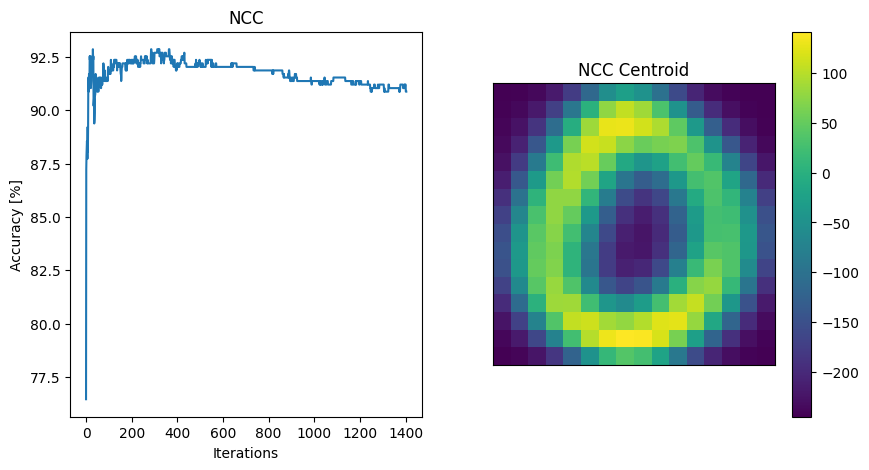

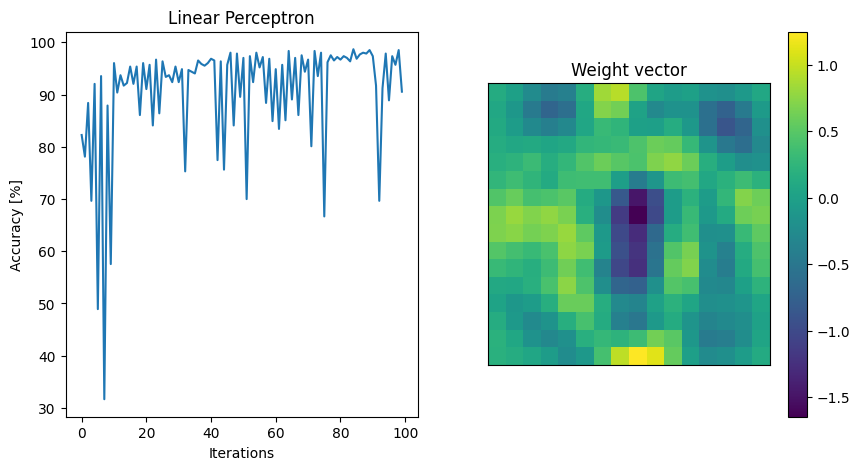

In [20]:
digits(0)
digit_p(0)